In [1]:
import os
from itertools import product
from astropy.io import fits
from astropy.table import Table
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import imageMethod as image_tasks
from lvmdrp.functions import rssMethod as rss_tasks
from lvmdrp.core.constants import SPEC_CHANNELS

# Instructions

This notebook implementes a quick reduction of the LVM data. Main asumptions are:

1. There is a `data_calib` directory containing master calibration frames for:
    - pixel mask (`lvm-mpixmask-{CAMERA}.fits`)
    - bias (`lvm-mbias-{CAMERA}.fits`)
    - dark (`lvm-mdark-{CAMERA}.fits`)
    - traces (`traces_{CAMERA}_p4.fits`)
    - wavelengths (`lvm-mwave_neon-{CAMERA}.fits`)
    - LSF (`lvm-mlsf_neon-{CAMERA}.fits`)

2. There is a `data_science` directory containing the **raw** target science exposures (`sdR-s-{CAMERA}-{EXPNUM:>08d}.fits.gz`)

3. Data products from this reduction can be stored in a directory `data_products` (this directory will be created by this notebook if it does not exists).

This reduction will push raw frames from preprocessing down to wavelength calibration.

In [2]:
# define paths
CALDIR = "data_calib/"
SCIDIR = "data_science/"
OUTDIR = "data_products/"
os.makedirs(OUTDIR, exist_ok=True)

# define cameras
SPECIDS = (1,2,3)
CHANNELS = "brz"
CAMERAS = [f"{channel}{spec}" for channel, spec in product(CHANNELS, SPECIDS)]

In [3]:
# target science directory
sci_paths = sorted([os.path.join(SCIDIR, sci_name) for sci_name in os.listdir(SCIDIR)])
print(sci_paths)

['data_science/sdR-s-b1-00002591.fits.gz', 'data_science/sdR-s-b2-00002591.fits.gz', 'data_science/sdR-s-b3-00002591.fits.gz', 'data_science/sdR-s-r1-00002591.fits.gz', 'data_science/sdR-s-r2-00002591.fits.gz', 'data_science/sdR-s-r3-00002591.fits.gz', 'data_science/sdR-s-z1-00002591.fits.gz', 'data_science/sdR-s-z2-00002591.fits.gz', 'data_science/sdR-s-z3-00002591.fits.gz']


In [4]:
for isci, sci_path in enumerate(sci_paths):
    # get basic metadata
    sci_header = fits.getheader(sci_path, ext=0)
    sci_camera = sci_header["CCD"]
    sci_exposure = sci_header["EXPOSURE"]
    
    # define calibration frames paths
    mpixmask_path = os.path.join(CALDIR, f"lvm-mpixmask-{sci_camera}.fits")
    mbias_path = os.path.join(CALDIR, f"lvm-mbias-{sci_camera}.fits")
    mdark_path = os.path.join(CALDIR, f"lvm-mdark-{sci_camera}.fits")
    mtrace_path = os.path.join(CALDIR, f"traces_{sci_camera}_p4.fits")
    mwave_path = os.path.join(CALDIR, f"lvm-mwave_neon-{sci_camera}.fits")
    mlsf_path = os.path.join(CALDIR, f"lvm-mlsf_neon-{sci_camera}.fits")
    mflat_path = drp.path.full("lvm_master", drpver=drp.drpver, tileid=1111, mjd=60147, camera=sci_camera, kind="mflat")
    
    # define products paths
    psci_path = os.path.join(OUTDIR, f"lvm-pobject-{sci_camera}-{sci_exposure:>08d}.fits")
    dsci_path = os.path.join(OUTDIR, f"lvm-dobject-{sci_camera}-{sci_exposure:>08d}.fits")
    xsci_path = os.path.join(OUTDIR, f"lvm-xobject-{sci_camera}-{sci_exposure:>08d}.fits")
    wsci_path = os.path.join(OUTDIR, f"lvm-wobject-{sci_camera}-{sci_exposure:>08d}.fits")
    
    # if os.path.isfile(wsci_path):
    #     print(f"skipping {wsci_path}, file already exist")
    #     continue
    
    # preprocess frame
    image_tasks.preproc_raw_frame(in_image=sci_path, out_image=psci_path, in_mask=mpixmask_path)
    
    # detrend frame
    image_tasks.detrend_frame(in_image=psci_path, out_image=dsci_path, in_bias=mbias_path, in_dark=mdark_path, in_slitmap=Table(drp.fibermap.data))
    
    # extract 1d spectra
    image_tasks.extract_spectra(in_image=dsci_path, out_rss=xsci_path, in_trace=mtrace_path, method="aperture", aperture=3)
    
    # wavelength calibrate & resample
    iwave, fwave = SPEC_CHANNELS[sci_camera[0]]
    rss_tasks.create_pixel_table(in_rss=xsci_path, out_rss=wsci_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)
    rss_tasks.resample_wavelength(in_rss=wsci_path, out_rss=wsci_path, method="linear", disp_pix=0.5, start_wave=iwave, end_wave=fwave, err_sim=10, parallel=0)
    
    # apply fiberflat correction
    rss_tasks.apply_fiberflat(in_rss=wsci_path, out_rss=wsci_path, in_flat=mflat_path)


[INFO]: starting preprocessing of raw image 'sdR-s-b1-00002591.fits.gz'
[ERROR]: cannot apply header fix: invalid literal for int() with base 10: ''
[INFO]: using header IMAGETYP = 'object'
[INFO]: exposure time 900.0 (s)
[INFO]: using header TRIMSEC = ['[1:2043, 2041:4080]', '[2078:4120, 2041:4080]', '[1:2043, 1:2040]', '[2078:4120, 1:2040]']
[INFO]: using header BIASSEC = ['[2044:2060, 2041:4080]', '[2061:2077, 2041:4080]', '[2044:2060, 1:2040]', '[2061:2077, 1:2040]']
[INFO]: using header GAIN = [2.71, 2.71, 2.68, 2.69] (e-/ADU)
[INFO]: median and standard deviation in OS quadrant 1: 974.00 +/- 1.13 (ADU)
[INFO]: median and standard deviation in OS quadrant 2: 982.00 +/- 1.14 (ADU)
[INFO]: median and standard deviation in OS quadrant 3: 983.00 +/- 1.29 (ADU)
[INFO]: median and standard deviation in OS quadrant 4: 982.00 +/- 1.29 (ADU)
[INFO]: using header RDNOISE = [3.0, 3.0, 2.8, 2.8] (e-)
[INFO]: flipping along X-axis
[INFO]: updating header with per quadrant stats
[INFO]: loading

In [16]:
target_expnum = 2591
specid = 2

spec_paths = []
for channel in CHANNELS:
    spec_path = os.path.join(OUTDIR, f"lvm-wobject-{channel}{specid}-{target_expnum:>08d}.fits")
    spec_paths.append(spec_path)

jsci_path = os.path.join(OUTDIR, f"lvm-object-sp{specid}-{target_expnum:>08d}.fits")
_ = rss_tasks.join_spec_channels(spec_paths, out_rss=jsci_path)

[INFO]: loading RSS files: ['data_products/lvm-wobject-b2-00002591.fits', 'data_products/lvm-wobject-r2-00002591.fits', 'data_products/lvm-wobject-z2-00002591.fits']
[INFO]: computing best wavelength array
[INFO]: new wavelength sampling: min = 0.5, max = 0.5
[INFO]: interpolating RSS data in new wavelength array
[INFO]: calculating weights for channel combination
[INFO]: combining channel data
[INFO]: writing output RSS to lvm-object-sp2-00002591.fits


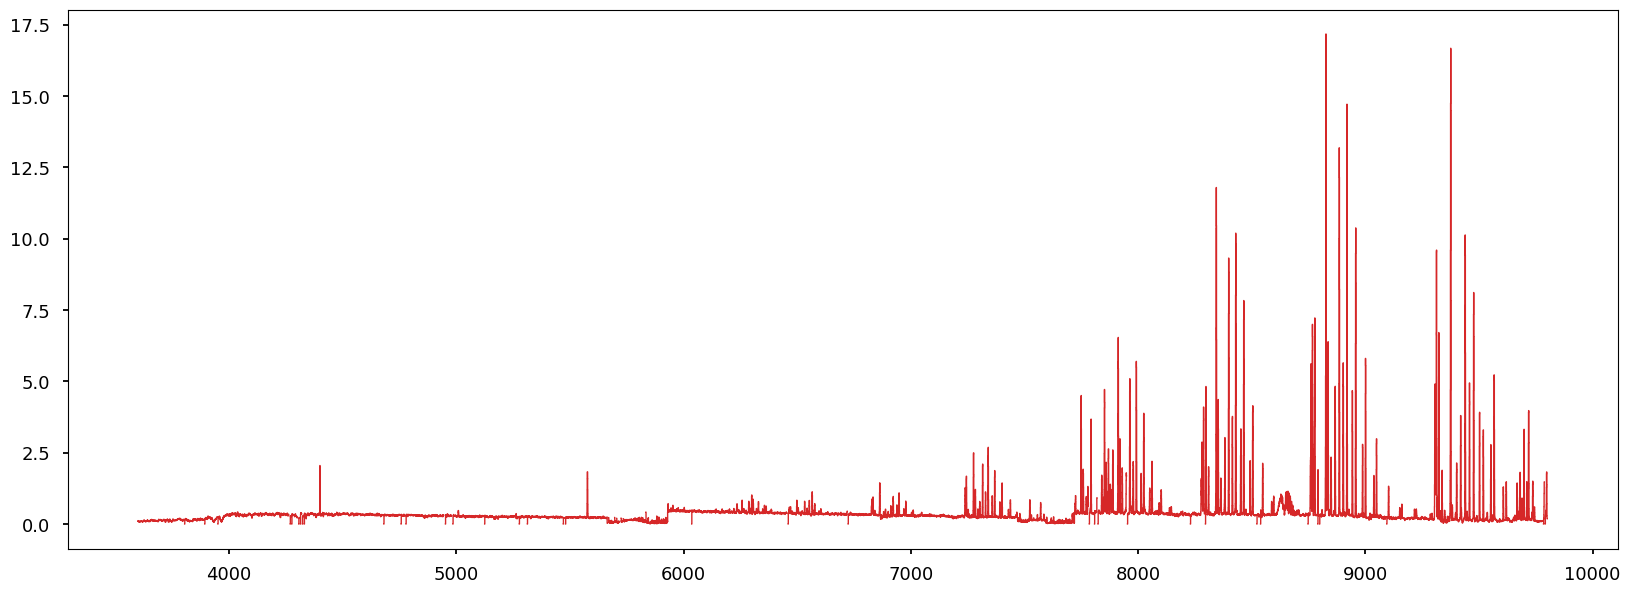

In [17]:
from lvmdrp.core import rss
import matplotlib.pyplot as plt

sci = rss.RSS()
sci.loadFitsData(jsci_path)
sci.apply_pixelmask()

plt.figure(figsize=(20,7))
plt.step(sci._wave, sci._data[319], lw=1, color="tab:red")
# plt.gca().set_yscale("log")